In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten, Dense, Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.losses import categorical_crossentropy, binary_crossentropy
from skimage.transform import resize

2024-09-03 09:26:56.325292: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 09:26:56.688242: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 09:26:56.690474: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-03 09:26:58.217959: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
full_path = lambda obj: f'../../assets/{obj}-tight.png'
CLASSES = ['bulbasaur', 'charmander', 'squirtle']

DIM = 200

In [3]:
def custom_loss(y_true, y_pred):
  # target: (row, col, depth, width, class1, class2, class3, object-present)
  bce = binary_crossentropy(y_true[:, :4], y_pred[:, :4]) # location is transformed by sigmoid into probability
  cce = categorical_crossentropy(y_true[:, 4:], y_pred[:, 4:])
  bce2 = binary_crossentropy(y_true[:, 7], y_pred[:, 7]) # object-present
  return bce * y_true[:, 7] + cce * y_true[:, 7] + 0.5 * bce2

In [4]:
def make_model():
  vgg = VGG16(
    input_shape=[DIM, DIM, 3],
    include_top=False, 
    weights='imagenet'
  )
  x = Flatten()(vgg.output)
  x1 = Dense(4, activation='sigmoid')(x)
  x2 = Dense(3, activation='softmax')(x)
  x3 = Dense(1, activation='sigmoid')(x)
  x = Concatenate()([x1, x2, x3])  
  model = Model(vgg.input, x)

  model.compile(
    loss=custom_loss,
    optimizer=Adam(learning_rate=0.0001)
  )
  model.summary()
  return model
model = make_model()

2024-09-03 09:27:00.836235: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-03 09:27:01.035924: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 200, 200, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 200, 200, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

found 3 pokemons with shape (48, 43, 4)


/tmp/ipykernel_7166/2712624149.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = np.array(imageio.imread(full_path(pokemon)))


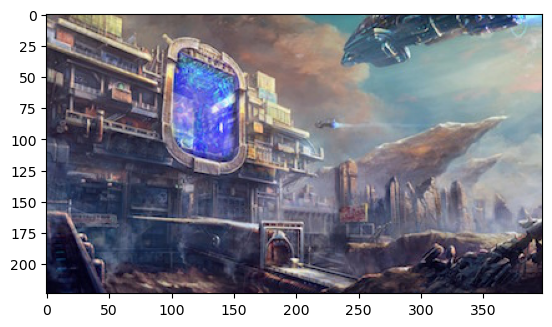

In [5]:
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip -P ../../assets/ > /dev/null 2>&1
!unzip -n ../../assets/backgrounds.zip  "backgrounds/*"  -d ../../assets/ > /dev/null 2>&1

import glob
import imageio

pokemons = []
for pokemon in CLASSES:
  img = np.array(imageio.imread(full_path(pokemon)))
  pokemons.append(img)
print(f"found {len(pokemons)} pokemons with shape {pokemons[0].shape}")

backgrounds = []
for path in glob.glob('../../assets/backgrounds/*.jpg'):
  img = np.array(image.load_img(path))
  backgrounds.append(img)
plt.imshow(backgrounds[0])

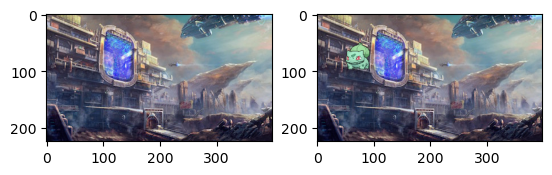

In [6]:
import random

def put_pokemon_on_background(bg, obj, obj_x_min, obj_y_min, obj_x_max, obj_y_max):
  mask = (obj[:, :, 3] == 0)
  bg_slice = bg[obj_y_min:obj_y_max, obj_x_min:obj_x_max, :]
  bg_slice *= np.expand_dims(mask, -1) # (H, W, 3) * (H, W, 1)
  bg_slice += obj[:, :, :3] # add pokemon to the background

# test it
bg = backgrounds[0].copy()
obj = pokemons[0]
_, axs = plt.subplots(1, 2)
axs[0].imshow(bg)
put_pokemon_on_background(bg, obj, 50, 50, 50 + obj.shape[1], 50 + obj.shape[0])
axs[1].imshow(bg)
plt.show()

Coords=[0.365 0.065 0.165 0.13 ]; class=charmander; appeared=1.0


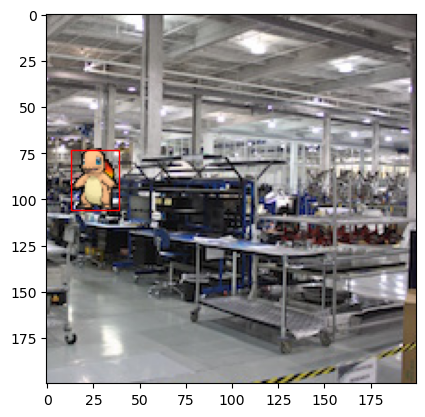

In [7]:
from matplotlib.patches import Rectangle
def image_generator(batch_size=64):
  while True:
    # Batch x Height x Width x Channels
    X = np.zeros((batch_size, DIM, DIM, 3))
    Y = np.zeros((batch_size, 8))
    for i in range(batch_size):
      bg = random.choice(backgrounds)

      bg_x_min = random.randint(0, bg.shape[1] - DIM)
      bg_y_min = random.randint(0, bg.shape[0] - DIM)
      bg_x_max = bg_x_min + DIM
      bg_y_max = bg_y_min + DIM

      X[i] = bg[bg_y_min:bg_y_max, bg_x_min:bg_x_max].copy()

      # 3 pokemons + 1 lack of any class, each 25% chance
      if appear := random.random() < 0.75:

        obj_idx = random.randint(0, len(pokemons) - 1)
        obj = pokemons[obj_idx]
        scale = 0.5 + random.random()
        new_height = int(obj.shape[0] * scale)
        new_width = int(obj.shape[1] * scale)
        obj = resize(obj, (new_height, new_width), preserve_range=True).astype(np.uint8)

        if random.random() > 0.5:
          obj = np.fliplr(obj)

        obj_x_min = random.randint(0, DIM - new_width)
        obj_y_min = random.randint(0, DIM - new_height)
        obj_x_max = obj_x_min + new_width
        obj_y_max = obj_y_min + new_height

        put_pokemon_on_background(X[i], obj, obj_x_min, obj_y_min, obj_x_max, obj_y_max)

        # target: (row, col, depth, width, class1, class2, class3, object-present)
        Y[i, 0] = obj_y_min / DIM
        Y[i, 1] = obj_x_min / DIM
        Y[i, 2] = new_height / DIM
        Y[i, 3] = new_width / DIM
        Y[i, 4 + obj_idx] = 1
        Y[i, 7] = appear

    yield X / 255.0, Y

print_result = lambda p: print(f'Coords={p[:4]}; class={CLASSES[p[4:7].argmax()]}; appeared={p[7]}')

X, Y = next(image_generator(1))
plt.imshow(X[0])
print_result(Y[0])
rect = Rectangle((Y[0][1] * DIM, Y[0][0] * DIM), Y[0][3] * DIM, Y[0][2] * DIM, linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)
plt.show()

In [8]:

model.fit(
  image_generator(8),
  steps_per_epoch=100,
  epochs=5
)
model.save('pokemons-on-background-localizer.h5')


Epoch 1/5


2024-09-03 09:27:08.927928: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 81920000 exceeds 10% of free system memory.
2024-09-03 09:27:08.998433: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 81920000 exceeds 10% of free system memory.
2024-09-03 09:27:12.464920: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 81920000 exceeds 10% of free system memory.
2024-09-03 09:27:12.605320: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 92160000 exceeds 10% of free system memory.
2024-09-03 09:27:12.608824: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 81920000 exceeds 10% of free system memory.


100/100 [==============================] - 404s 4s/step - loss: 2.5543
Epoch 2/5
100/100 [==============================] - 399s 4s/step - loss: 1.6154
Epoch 3/5
100/100 [==============================] - 398s 4s/step - loss: 1.5063
Epoch 4/5
100/100 [==============================] - 398s 4s/step - loss: 1.4059
Epoch 5/5
100/100 [==============================] - 398s 4s/step - loss: 1.4621


/home/jakubner/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
# from keras.models import load_model
# model = load_model('pokemons-on-background-localizer.h5')

(1, 200, 200, 3)
1/1 [==============================] - 0s 308ms/step
Coords=[0.06156355 0.03972539 0.35379833 0.21168092]; class=charmander; appeared=0.9999697208404541


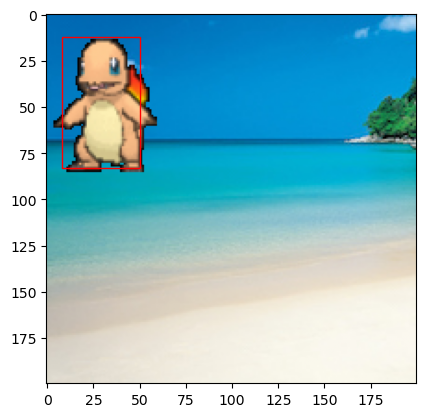

(1, 200, 200, 3)
1/1 [==============================] - 0s 129ms/step
Coords=[0.10998896 0.69463986 0.14581187 0.17925015]; class=squirtle; appeared=1.0


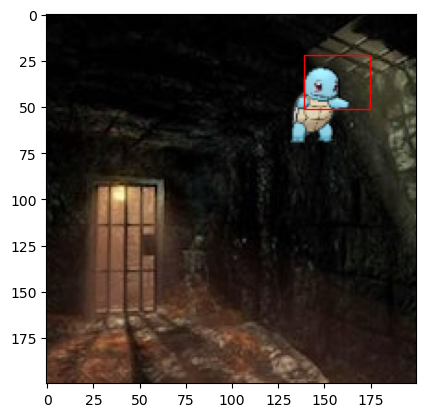

(1, 200, 200, 3)
1/1 [==============================] - 0s 129ms/step
Coords=[0.4370817  0.17641218 0.3200353  0.22014426]; class=squirtle; appeared=1.0


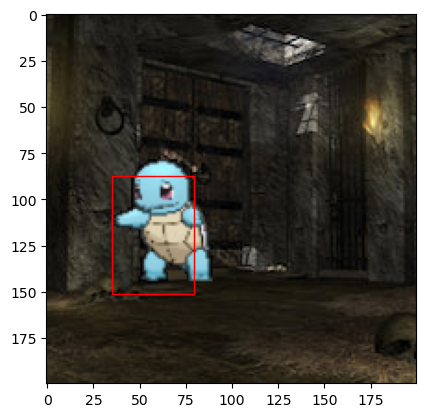

(1, 200, 200, 3)
1/1 [==============================] - 0s 128ms/step
Coords=[0.47415143 0.43891624 0.15768076 0.14616852]; class=charmander; appeared=0.005225023254752159


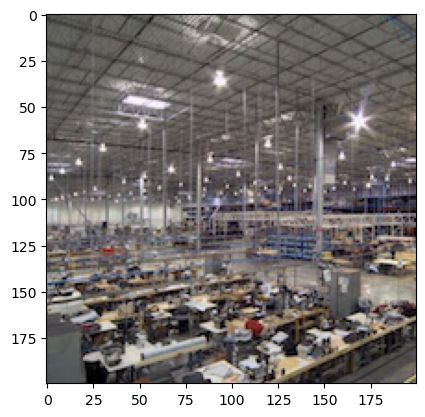

(1, 200, 200, 3)
1/1 [==============================] - 0s 135ms/step
Coords=[0.4888676  0.43368027 0.15660535 0.13747314]; class=charmander; appeared=0.00478994520381093


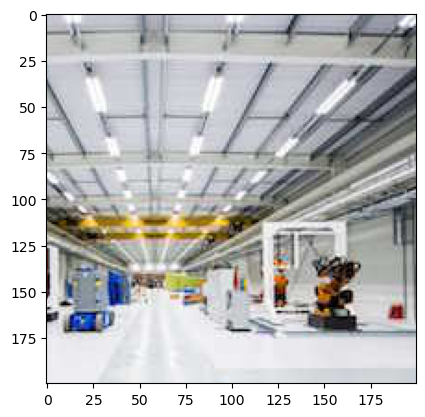

In [10]:
from matplotlib.patches import Rectangle

def make_prediction():
  X, _ = image_generator(1).__next__()
  print(X.shape)
  result = model.predict(X)[0]
  print_result(result)


  fig, ax = plt.subplots(1)
  ax.imshow(X[0], cmap='gray')
  if result[7] > 0.5:
    result[:4] *= DIM
    rect = Rectangle(
      (result[1], result[0]),
      result[3], result[2],
      linewidth=1, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)
  plt.show()

make_prediction()
make_prediction()
make_prediction()
make_prediction()
make_prediction()